In [1]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from autoencoder import CustomDataset, Autoencoder, Autoencoder_no_lineal
from collections import defaultdict
import json

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

train_set_autoencoder = CustomDataset(train_set_orig)
valid_set_autoencoder = CustomDataset(valid_set_orig)

In [3]:
train_set_autoencoder = CustomDataset(train_set_orig)
valid_set_autoencoder = CustomDataset(valid_set_orig)

In [4]:
train_loader = DataLoader(train_set_autoencoder, batch_size=100, shuffle=True, num_workers=os.cpu_count()-1)
valid_loader = DataLoader(valid_set_autoencoder, batch_size=100, shuffle=False, num_workers=os.cpu_count()-1)

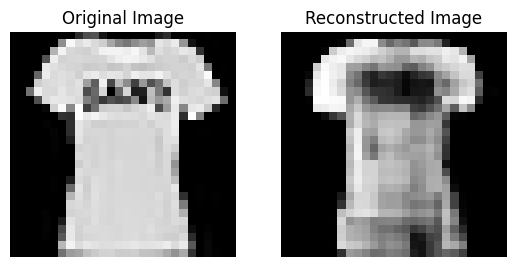

In [52]:
import random

id_to_load = 2

# load model id to load and select 1 random image from validation set and plot it and its reconstruction
results_folder = './results/'
Files = os.listdir(results_folder)
model_files = [f for f in Files if f.endswith(f'{id_to_load}.pt')]

json_files = [f for f in Files if f.endswith(f'{id_to_load}.json')]

model_file = model_files[0]
json_file = json_files[0]

# load json file
with open(os.path.join(results_folder, json_file)) as f:
    results = json.load(f)
    config = results['config']
    if config['lineal']:
        model = Autoencoder(config['dropout'], config['l_size'])
    else:
        model = Autoencoder_no_lineal(config['dropout'])
    model.load_state_dict(torch.load(os.path.join(results_folder, model_file), map_location='cpu', weights_only=True))

model.eval()

# select random image from validation set and plot it
# Select a random image from the validation set
random_index = random.randint(0, len(train_set_orig) - 1)
random_image, _ = train_set_orig[random_index]

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(random_image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Generate the reconstructed image
with torch.no_grad():
    reconstructed_image = model(random_image.unsqueeze(0)).squeeze()

# Plot the reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()

In [54]:
import os
import json
import torch
from autoencoder import Autoencoder, Autoencoder_no_lineal

# Ruta a la carpeta de resultados
results_folder = './results/'
files = os.listdir(results_folder)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {}

json_files = [file for file in files if file.endswith('.json')]
model_files = [file for file in files if file.endswith('.pt')]

for file in json_files:
    with open(os.path.join(results_folder, file), 'r') as f:
        result = json.load(f)
        config_id = result['config']['id']
        model_path = os.path.join(results_folder, f"model_{config_id}.pt")
        
        if result['config'].get('lineal', True):
            dropout = result['config']['dropout']
            l_size = result['config']['l_size']
            model = Autoencoder(dropout=dropout, l_size=l_size)
        else:
            model = Autoencoder_no_lineal(dropout=result['config']['dropout'])
        
        # Cargar el estado del modelo
        aux = torch.load(model_path, map_location=device, weights_only=True)
        
        try:
            model.load_state_dict(aux)
        except RuntimeError as e:
            print(f"Error al cargar el modelo para la configuración {config_id}: {e}")

            # dimensiones de aux
            print(aux.keys())
            # dimensiones de model
            print(model.state_dict().keys())
            continue
        
        models[config_id] = {
            'config': result['config'],
            'model': model
        }

print("Modelos cargados correctamente:", models.keys())

Modelos cargados correctamente: dict_keys([4, 2, 3, 1])


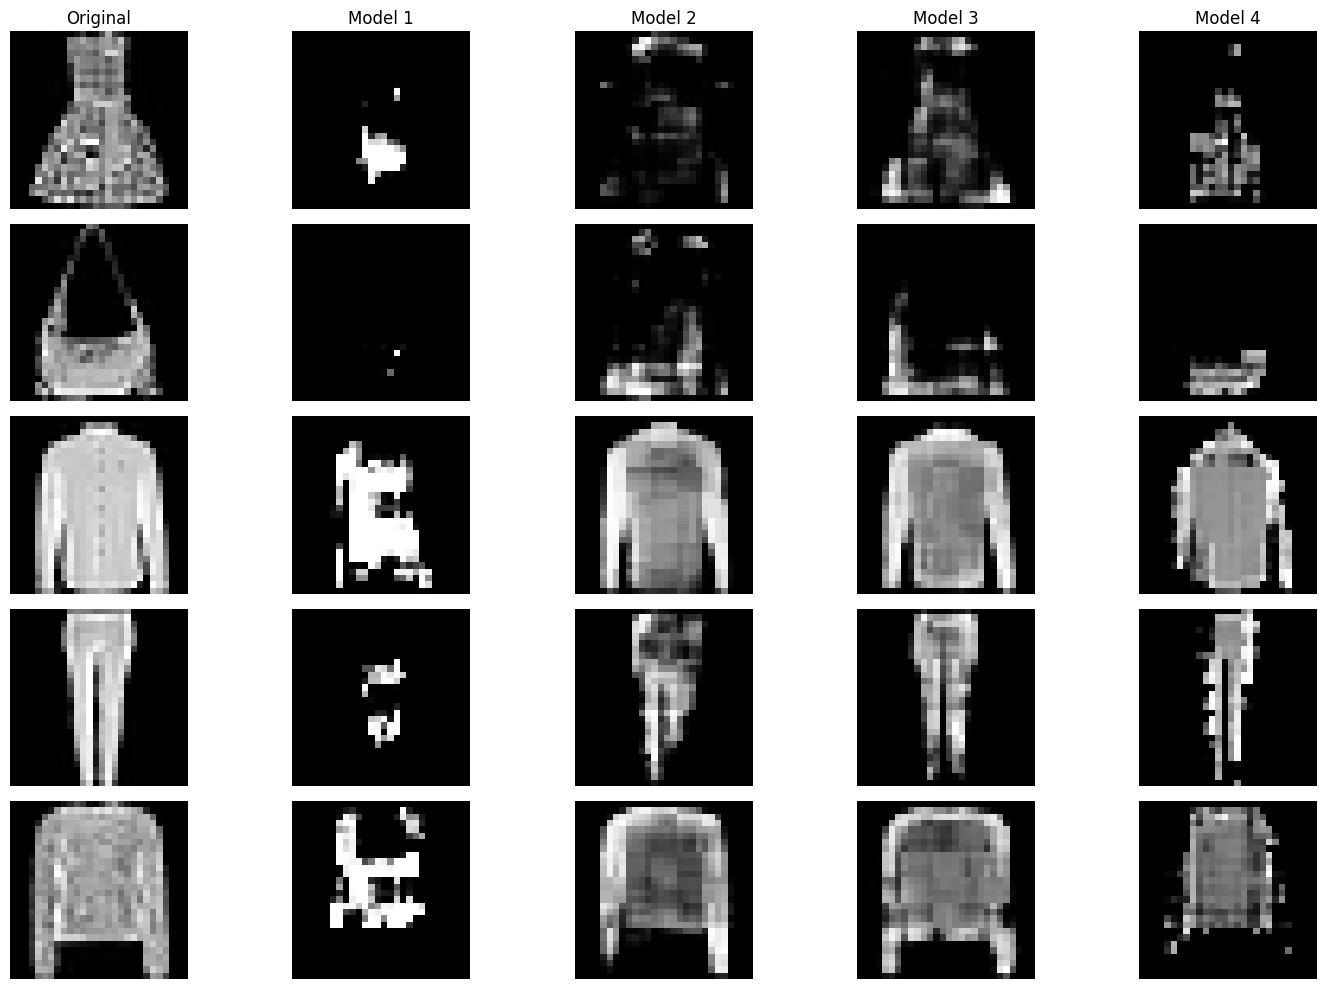

In [65]:
import random

# Select 5 random images from the validation dataset
random_indices = random.sample(range(len(valid_set_orig)), 5)
random_images = [valid_set_orig[i][0] for i in random_indices]

# Set models to evaluation mode
for model_info in models.values():
    model_info['model'].eval()

# Plot the images
fig, axes = plt.subplots(len(random_images), len(models) + 1, figsize=(15, 10))
fig.tight_layout(pad=3.0)

for i, img in enumerate(random_images):
    # Plot original image
    axes[i, 0].imshow(img.squeeze(), cmap='gray')
    if i == 0:
        axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    # Plot generated images from each model in order
    for j, config_id in enumerate(sorted(models.keys())):
        model_info = models[config_id]
        with torch.no_grad():
            generated_img = model_info['model'](img.unsqueeze(0).to(device)).cpu().squeeze()
        axes[i, j + 1].imshow(generated_img, cmap='gray')
        if i == 0:
            axes[i, j + 1].set_title(f'Model {config_id}')
        axes[i, j + 1].axis('off')

plt.tight_layout()
plt.show()